# MyND Offline Processing: Data Analysis
Author: Geeling Chau<br> 
Description: Process xdf files recorded from experimental sessions to determine file eligibility and data feature extraction.<br>
Sources: 
- Ollie's Segment Speller Offline Processing Code https://github.com/ollie-d/SegSpeller/blob/master/Offline%20Processing.ipynb 
- neurodsp https://github.com/neurodsp-tools/neurodsp


## TODO
- [X] standard error bars
- [ ] reaction time analysis
- [ ] Psychopy adjust difficulty 
- [ ] flash memes

## Imports

In [21]:
from helperFunctions import *
from constants import *
from dataAnalysisFunctions import *


import warnings
warnings.filterwarnings('ignore')

## Helper Functions

## Main

### Get Data

In [3]:
'''
Files that work with this notebook: 
participant_P004_exp001_block_full_start.xdf # full start
participant_P004_exp002_block_full_start.xdf # This should work: after restarting computer
participant_P004_exp003_block_full_start.xdf # This should work too
participant_P004_exp001_block_full_short.xdf # Works
participant_P004_exp001_block_full_long.xdf # Works

participant_P001_exp001_block_full_long.xdf # Me, very sleepy. 

'''

XDF_Data = loadxdf("../data/P004/participant_P004_exp001_block_full_long.xdf")
if StreamType.EEG.value in XDF_Data : 
    eeg_fs = int(XDF_Data[StreamType.EEG.value][StreamType.FS.value])
    print("eeg_fs = ", eeg_fs)
if StreamType.EYE.value in XDF_Data : 
    time_differences_eye_tracker = [XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE][i+1]-XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE][i] for i in range(len(XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE])-1)]
    mean_fs_eye_tracker = 1/np.mean(time_differences_eye_tracker)
    eye_fs = int(mean_fs_eye_tracker)
    print("eye_fs = ", eye_fs)
# Trim the data to only include the time PsychoPy was running
XDF_Data = epochByMarkIndex(0, -1, XDF_Data)

markers = np.array(XDF_Data[MARKER_STREAM_TYPE][DATA_STREAM_TYPE][:,0])
marker_indexes = {}
for index, marker in enumerate(markers): 
    marker_indexes[marker] = index
    


eeg_fs =  250
eye_fs =  37


In [4]:
# Recording data checks (whether all markers are there etc)
markersFound = True
for marker_key in PSYCHO_PY_MARKERS : 
    if PSYCHO_PY_MARKERS[marker_key] not in markers: 
        markersFound = False 
        print("Missing Marker:", PSYCHO_PY_MARKERS[marker_key])
print("All Markers Found?", markersFound)


Missing Marker: --InstructionStart
Missing Marker: --InstructionStop
Missing Marker: --LettersShown
All Markers Found? False


## Filtering

### Filter 1-50 Hz

In [5]:
filtered_data = filterStreamStructEEG(XDF_Data)

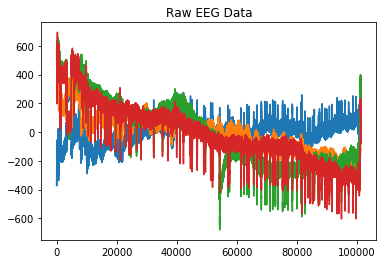

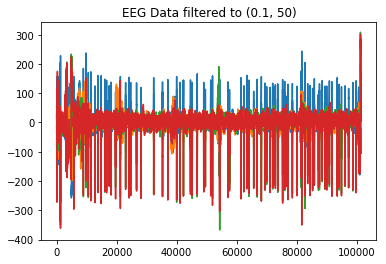

In [6]:
# Check filtering
for channel in channels: 
    eeg_data = XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]]
    plt.plot(eeg_data)
plt.title("Raw EEG Data")
plt.show()

for channel in channels: 
    eeg_data = filtered_data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]]
    plt.plot(eeg_data)
plt.title("EEG Data filtered to " + str(f_range))
margin =  800 #len(freq) // 2 means all. 600 to see 60Hz
plt.show()

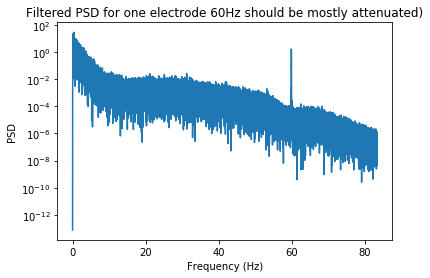

In [7]:
freq, psd = signal.periodogram(filtered_data[StreamType.EEG.value][StreamType.DATA.value][:,channels["right_eeg"]], fs=int(eeg_fs), scaling='spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD') # not sure what the unit is...
plt.title('Filtered PSD for one electrode 60Hz should be mostly attenuated)')
plt.semilogy(freq[: int(len(freq) / 1.5)], psd[: int(len(freq) / 1.5)])
plt.show()


## Clean artifacts from VEOG

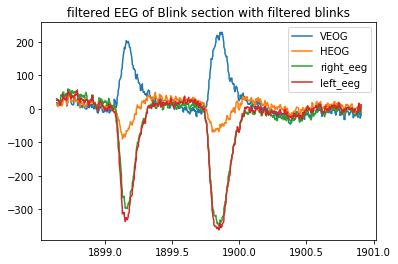

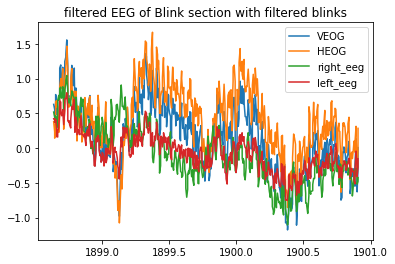

In [13]:
#Filter the entire EEG data

# Show original blink data
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=filtered_data)
blink_data=new_data[0]

plt.plot(blink_data[StreamType.EEG.value][StreamType.TIME.value], blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section with filtered blinks")
plt.show()

#Filter the entire EEG data
filtered_cleaned_data  = getCleanedSignal(filtered_data, verbose=False)


# Show the cleaned data at the blink section
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=filtered_cleaned_data)
blink_data = new_data[0]

plt.plot(blink_data[StreamType.EEG.value][StreamType.TIME.value], blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section with filtered blinks")
plt.show()


## Get points for each section

In [10]:
# Get sections
numSections = getNumSections(filtered_cleaned_data)
article_sections = list()
for i in range(numSections) : 
    article_sections.append(getArticleSectionData("response", i, filtered_cleaned_data))


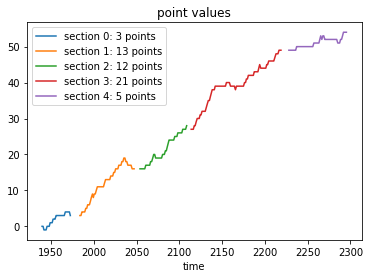

In [11]:
for i, article_section in enumerate(article_sections):
    data, time = getPointsAfterEachWord(article_section)
    num_delta_points = getTotalPoints(article_section)
    plt.plot(time[:], data[:], label="section " + str(i) + ": " + str(num_delta_points) + " points")
plt.title("point values")
plt.xlabel("time")
plt.legend()
plt.show()

## Get meme show and hide times

In [22]:
binning=list(np.arange(.5, 30, 2))
intervals = getIntervals(binning)

In [23]:
# Determine the time frames in which the memes are shown
meme_is_shown_data, a, b = getLabelBoundSingleLabelData("memeShown", "memeHidden", filtered_cleaned_data, go_backward=False)
meme_eeg_data, meme_averages, meme_power_ratio = getLeftRightData(meme_is_shown_data, binning, verbose=False)
meme_shown_times = list() 
for data in meme_is_shown_data:
    start_time = data[StreamType.EEG.value][StreamType.TIME.value][0]
    end_time = data[StreamType.EEG.value][StreamType.TIME.value][-1]
    meme_shown_times.append((start_time, end_time))

## Finer Epoching
Target vs Nontarget <br> 
SpacePressed vs NoSpacePressed <br> 
Meme vs No Meme

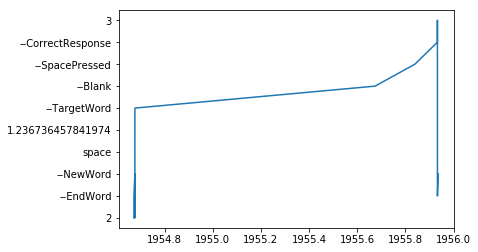

In [24]:
plt.plot(XDF_Data[StreamType.MARKER.value][StreamType.TIME.value][197:210], markers[197:210])

In [25]:
# Construct data frame 
new_word_data, a, t_data = getTimeBoundSingleLabelData("newWord", filtered_cleaned_data, time_before=0.5, time_after=1.5)
points = [getTotalPoints(data) for data in new_word_data] 

data_info = dict() 
data_info["data_index"] = list() 
data_info["data"] = list() 
data_info["is_target"] = list() 
data_info["is_pressed"] = list() 
data_info["has_meme"] = list() 
data_info["time"] = list() 
data_info["points"] = list() 
data_info["section_number"] = list()

start_marker_string = getLabelMarkerString("newWord")
end_marker_string = getLabelMarkerString("endWord")
target_word_string = getSingleLabelMarkerString("targetWord")
space_pressed_string = getSingleLabelMarkerString("spacePressed")
response_start_string = getSectionMarkerString("response")[0]
section_number = 0

end_times = list()
for i, point in enumerate(points):
    if(response_start_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value]) : 
        section_number += 1
    
    # Find this word's start and end indexes 
    marker_indexes = getMarkerIndexes(new_word_data[i])
    start_word_index = marker_indexes[start_marker_string][0]
    end_word_index = marker_indexes[end_marker_string][-1]
    end_time = float(new_word_data[i][StreamType.MARKER.value][StreamType.TIME.value][end_word_index])
    end_times.append(end_time)
    # Determine if meme was shown
    has_meme = False
    for meme_shown_interval in meme_shown_times: 
        if (end_time > meme_shown_interval[0] and end_time < meme_shown_interval[1]) :
            has_meme = True
            break

    
    # Determine if word is a target word
    is_target = False
    if target_word_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value][start_word_index:end_word_index] : 
        is_target = True
    
    # Determine if word was pressed on 
    is_pressed = False
    if space_pressed_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value][start_word_index:end_word_index] : 
        is_pressed = True
    
    
    data_info["data_index"].append(i)
    data_info["data"].append(new_word_data[i])
    data_info["is_target"].append(is_target)
    data_info["is_pressed"].append(is_pressed)
    data_info["has_meme"].append(has_meme)
    data_info["time"].append(t_data[i])
    data_info["points"].append(point)
    data_info["section_number"].append(section_number)

df = pd.DataFrame.from_dict(data_info)

In [27]:
df.head(-5)

,data_index,data,is_target,is_pressed,has_meme,time,points,section_number
0,0,"{'markers': {'time': [1938.337366205731, 1938....",False,False,False,1938.347489,0,1
1,1,"{'markers': {'time': [1939.253629462901, 1939....",False,False,False,1939.474581,0,1
2,2,"{'markers': {'time': [1940.4219485919914, 1940...",False,True,False,1940.657741,-1,1
3,3,"{'markers': {'time': [1941.253947142525, 1941....",False,False,False,1941.707920,0,1
4,4,"{'markers': {'time': [1942.6713444755837, 1942...",False,False,False,1942.907427,0,1
...,...,...,...,...,...,...,...,...
273,273,"{'markers': {'time': [2283.8379131826596, 2284...",False,True,True,2284.089110,-1,5
274,274,"{'markers': {'time': [2285.08591128246, 2285.3...",False,False,False,2285.339283,0,5
275,275,"{'markers': {'time': [2286.2365523938365, 2286...",False,False,False,2286.456323,0,5
276,276,"{'markers': {'time': [2287.2692575691217, 2287...",True,True,False,2287.490539,1,5


In [28]:
from neurodsp.timefrequency import amp_by_time

In [31]:
df.loc[0]

data_index                                                        0
data              {'markers': {'time': [1938.337366205731, 1938....
is_target                                                     False
is_pressed                                                    False
has_meme                                                      False
time                                                        1938.35
points                                                            0
section_number                                                    1
Name: 0, dtype: object

In [41]:
len(df)

283

In [63]:
amp_rights = list()
amp_lefts = list() 
cutoff = 499
alpha = (8, 12)
theta = (4, 7)
band = alpha
for i in range(len(df)): 
    sig_right = df.loc[i]["data"][StreamType.EEG.value][StreamType.DATA.value][:, channels["right_eeg"]]
    amp_right = amp_by_time(sig_right, eeg_fs, band)[:cutoff]
    amp_rights.append(amp_right)

    sig_left = df.loc[i]["data"][StreamType.EEG.value][StreamType.DATA.value][:, channels["left_eeg"]]
    amp_left = amp_by_time(sig_left, eeg_fs, band)[:cutoff]
    amp_lefts.append(amp_left)

In [52]:
sig = filtered_cleaned_data[StreamType.EEG.value][StreamType.DATA.value][:, channels["right_eeg"]]
amp = amp_by_time(sig, eeg_fs, (8, 12))

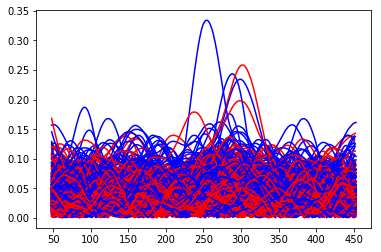

In [64]:
for i in range(len(df)): 
    plt.plot(amp_rights[i], color="b")
    plt.plot(amp_lefts[i], color="r")
plt.show()

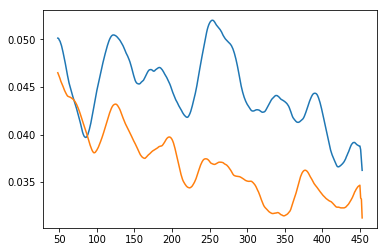

In [74]:
plt.plot(np.nanmean(amp_rights, axis=0))
plt.plot(np.nanmean(amp_lefts, axis=0))

In [ ]:
plt.plot(np.nanmean(amp_rights, axis=0))


In [66]:
focused_df = df[((df["is_pressed"] == True) & (df["is_target"] == True))]


In [ ]:
def getLeftRight

In [72]:
amp_rights = list()
amp_lefts = list() 

for i, data in focused_df.iterrows(): 
    sig_right = data["data"][StreamType.EEG.value][StreamType.DATA.value][:, channels["right_eeg"]]
    amp_right = amp_by_time(sig_right, eeg_fs, band)[:cutoff]
    amp_rights.append(amp_right)

    sig_left = data["data"][StreamType.EEG.value][StreamType.DATA.value][:, channels["left_eeg"]]
    amp_left = amp_by_time(sig_left, eeg_fs, band)[:cutoff]
    amp_lefts.append(amp_left)

In [73]:
data

data_index                                                      279
data              {'markers': {'time': [2290.426289098024, 2290....
is_target                                                      True
is_pressed                                                     True
has_meme                                                       True
time                                                        2290.91
points                                                            1
section_number                                                    5
Name: 279, dtype: object

In [68]:
mispress_df = df[((df["is_pressed"] == True) & (df["is_target"] == False)) | ((df["is_pressed"] == False) & (df["is_target"] == True))]


In [69]:
mispress_df

,data_index,data,is_target,is_pressed,has_meme,time,points,section_number
2,2,"{'markers': {'time': [1940.4219485919914, 1940...",False,True,False,1940.657741,-1,1
28,28,"{'markers': {'time': [1971.2642844077952, 1971...",True,False,False,1971.496993,-1,1
43,43,"{'markers': {'time': [1998.1694939603228, 1998...",True,False,False,1998.436857,-1,2
75,75,"{'markers': {'time': [2036.1553617195057, 2036...",True,False,False,2036.393808,-1,2
77,77,"{'markers': {'time': [2038.391306719316, 2038....",False,True,False,2038.610598,-1,2
81,81,"{'markers': {'time': [2043.30722363575, 2043.5...",False,True,False,2043.563060,-1,2
100,100,"{'markers': {'time': [2070.9627691911337, 2071...",False,True,False,2071.182798,-1,3
133,133,"{'markers': {'time': [2112.7532563497366, 2112...",False,True,False,2112.761214,-1,4
172,172,"{'markers': {'time': [2158.34533913381, 2158.5...",True,False,False,2158.599454,-1,4
177,177,"{'markers': {'time': [2164.1796777303784, 2164...",True,False,True,2164.399692,-1,4


In [28]:
unfocused_df = df[((df["is_pressed"] == False) & (df["is_target"] == True))]
unfocused_data = unfocused_df["data"].values
unfocused_windows = getWindowsList(unfocused_df)
unfocused_freqs, unfocused_psds, unfocused_psd_avg = getFreqsAndPSD(unfocused_windows) 
unfocused_power_ratio = [getPowerRatio(data[:499], binning) for data in unfocused_windows]

unfocused_sem = getSEM(unfocused_power_ratio)
unfocused_power_ratio_avg = np.mean(unfocused_power_ratio, axis=0)



focused_df = df[((df["is_pressed"] == True) & (df["is_target"] == True))]
focused_data = focused_df["data"].values
focused_windows = getWindowsList(focused_df)
focused_freqs, focused_psds, focused_psd_avg = getFreqsAndPSD(focused_windows) 
focused_power_ratio = [getPowerRatio(data[:499], binning) for data in focused_windows]

focused_sem = getSEM(focused_power_ratio)
focused_power_ratio_avg = np.mean(focused_power_ratio, axis=0)


super_focused_df = df[((df["is_pressed"] == True) & (df["is_target"] == True) & (df["has_meme"] == True))]
super_focused_data = super_focused_df["data"].values
super_focused_windows = getWindowsList(super_focused_df)
super_focused_freqs, super_focused_psds, super_focused_psd_avg = getFreqsAndPSD(super_focused_windows) 
super_focused_power_ratio = [getPowerRatio(data[:499], binning) for data in super_focused_windows]

super_focused_sem = getSEM(super_focused_power_ratio)
super_focused_power_ratio_avg = np.mean(super_focused_power_ratio, axis=0)


super_unfocused_df = df[((df["is_pressed"] == False) & (df["is_target"] == True) & (df["has_meme"] == True))]
super_unfocused_data = super_unfocused_df["data"].values
super_unfocused_windows = getWindowsList(super_unfocused_df)
super_unfocused_freqs, super_unfocused_psds, super_unfocused_psd_avg = getFreqsAndPSD(super_unfocused_windows) 
super_unfocused_power_ratio = [getPowerRatio(data[:499], binning) for data in super_unfocused_windows]

super_unfocused_sem = getSEM(super_unfocused_power_ratio)
super_unfocused_power_ratio_avg = np.mean(super_unfocused_power_ratio, axis=0)


mispress_df = df[((df["is_pressed"] == True) & (df["is_target"] == False))]
mispress_data = mispress_df["data"].values
mispress_windows = getWindowsList(mispress_df)
mispress_freqs, mispress_psds, mispress_psd_avg = getFreqsAndPSD(mispress_windows) 
mispress_power_ratio = [getPowerRatio(data[:499], binning) for data in mispress_windows]

mispress_sem = getSEM(mispress_power_ratio)
mispress_power_ratio_avg = np.mean(mispress_power_ratio, axis=0)
